### 1. Obtain the canonical kernel

In [1]:
# compute empirical NTK through neural-tangents library
import jax
from jax import random, grad, jit
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
import jax.example_libraries.stax as ostax
from jax.example_libraries import optimizers
from jax.nn.initializers import zeros
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')

def get_ntk_fn(apply_fn):
    kwargs = dict(
        f=apply_fn,
        trace_axes=(),
        vmap_axes=0
    )

    # Different NTK implementations
    jacobian_contraction = jit(nt.empirical_ntk_fn(
        **kwargs, implementation=nt.NtkImplementation.JACOBIAN_CONTRACTION))

    return jacobian_contraction

def input_mapping(x, B): 
    '''Random Fourier Feature Mapping'''
    if B is None:
        return x
    else:
        x_proj = (2.*jnp.pi*x) @ B.T
        return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)


def make_mlp(num_layers=4, num_channels=512, num_outputs=1):
    layers = []
    for _ in range(num_layers-1):
        layers.append(ostax.Dense(num_channels))
        layers.append(ostax.Relu)
    layers.append(ostax.Dense(num_outputs))
    init_fn, apply_fn = ostax.serial(*layers)
    return init_fn, apply_fn

# Train model with given hyperparameters and data
def train_model(init_learning_rate, iters, train_data, B, key):

    # initialize the MLP
    init_fn, apply_fn = make_mlp()
    _, params = init_fn(key, (-1, B.shape[0]*2))
    # params = [ [jnp.zeros_like(p, dtype=p.dtype) for p in l ] for l in params]
    # params = [tuple(l) for l in params]

    # get the empirical NTK function
    ntk_fn = get_ntk_fn(apply_fn)
    rff_ntk_fn = jit(lambda params, x, B: ntk_fn(input_mapping(x, B), input_mapping(x, B), params))
    
    # cosine learning rate schedule
    learning_rate = lambda t: 0.5 * init_learning_rate * (1 + jnp.cos(jnp.pi * t / iters))

    # SGD optimizer
    opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
    opt_update = jit(opt_update)
    opt_state = opt_init(params)

    # loss function
    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: jnp.mean((model_pred(params, x) - y) ** 2))
    model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))


    ntk_logs = []
    preds = []
    proc_bar = tqdm(range(iters), desc='train iter', leave=False)

    # init
    val_loss = model_loss(get_params(opt_state), *train_data)
    proc_bar.set_postfix({'loss': f"{val_loss:.4f}"})
    ntk_logs.append(rff_ntk_fn(get_params(opt_state), train_data[0], B))
    preds.append(model_pred(get_params(opt_state), train_data[0]))

    for i in proc_bar:
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if (i+1) % 100 == 0:
            val_loss = model_loss(get_params(opt_state), *train_data)
            proc_bar.set_postfix({'loss': f"{val_loss:.4f}"})
            ntk_logs.append(rff_ntk_fn(get_params(opt_state), train_data[0], B))
            preds.append(model_pred(get_params(opt_state), train_data[0]))

    return {
        'state': get_params(opt_state),
        'ntk_logs': ntk_logs,
        'preds': preds, 
    }

2024-01-31 09:54:49.613569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def f_star(x):
    y = jnp.sin(x)
    return y

In [3]:
# set random seed
seed = 0
key = random.PRNGKey(seed)

n_samples = 100
x_train = jnp.linspace(-jnp.pi, jnp.pi, n_samples).reshape(-1, 1)
y_train = f_star(x_train)

lr = 1e-3
iters = 5000
sigma = 2.
mapping_size = 256

B = random.normal(key, (mapping_size, 1)) * sigma

In [4]:
result_dict = train_model(lr, iters, (x_train, y_train), B, key=key)
canonical_kernel = result_dict['ntk_logs'][-1]

train iter:   0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
import functools


def format_plot(x=None, y=None, fontsize=20):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=fontsize)
  if y is not None:
    plt.ylabel(y, fontsize=fontsize)


def plot_fn(x_train, y_train, *fs):
    x_train, y_train = x_train.flatten(), y_train.flatten()
    sorted_indices = jnp.argsort(x_train)
    x_train, y_train = x_train[sorted_indices], y_train[sorted_indices]
    plt.plot(x_train, y_train, 'r-', label='$f^*$', linewidth=2)
    
    colors = ['b', 'g', 'c', 'k']
    # linestyles = ['-.', '--', ':', '.']
    linestyles = ['--']
    for i, f_dict in enumerate(fs):
      label, f = f_dict['label'], f_dict['f'].flatten()
      plot_style = colors[i % len(colors)] + linestyles[i % len(linestyles)]
      plt.plot(x_train, f[sorted_indices], plot_style, linewidth=1.4, label=label)

    plt.xlim([-jnp.pi, jnp.pi])
    plt.ylim([-1.05, 1.05])

    format_plot('x', 'y', fontsize=15)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()


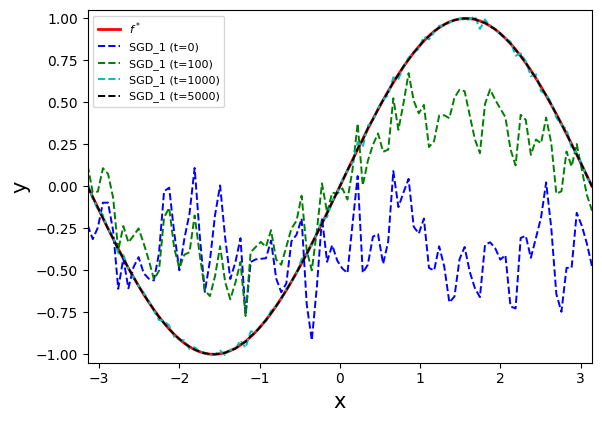

In [6]:
mlp1_preds = result_dict['preds']
mlp1_pred_t = [dict(f=mlp1_preds[0], label=f"SGD_1 (t=0)")]
mlp1_pred_t.extend([dict(f=mlp1_preds[i], label=f"SGD_1 (t={i*100})") for i in range(1, 2, 1)])
mlp1_pred_t.extend([dict(f=mlp1_preds[i], label=f"SGD_1 (t={i*100})") for i in range(10, 20, 10)])
mlp1_pred_t.append(dict(f=mlp1_preds[-1], label="SGD_1 (t=5000)"))
plot_fn(x_train, y_train, *mlp1_pred_t)
legend = functools.partial(plt.legend, fontsize=8)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

### 2. Use canonical kernel obtained above for nonparameteric functional gradient descent

In [7]:
def fgd_update(lr, f, canonical_kernel, dLdf):
    f = f - lr * canonical_kernel @ dLdf
    return f

def train_model_fgd(f, iters, lr, y_train, canonical_kernel):
    # cosine learning rate schedule
    learning_rate = lambda t: 0.5 * lr * (1 + jnp.cos(jnp.pi * t / iters))

    # loss function
    model_loss = jit(lambda f, y: jnp.mean((f - y) ** 2))

    fgd_logs = []
    proc_bar = tqdm(range(iters), desc='train iter', leave=False)
    fgd_logs.append(f)
    for step in proc_bar:
        dLdf = grad(model_loss)(f, y_train)
        f = fgd_update(learning_rate(step), f, canonical_kernel, dLdf)
        if (step+1) % 100 == 0:
            fgd_logs.append(f)
    return fgd_logs

In [8]:
# initial f as mlp1_{t=0}
f = mlp1_preds[0]

canonical_kernel = canonical_kernel.reshape(-1, canonical_kernel.shape[0])
fgd_logs = train_model_fgd(f, iters, lr, y_train, canonical_kernel)

train iter:   0%|          | 0/5000 [00:00<?, ?it/s]

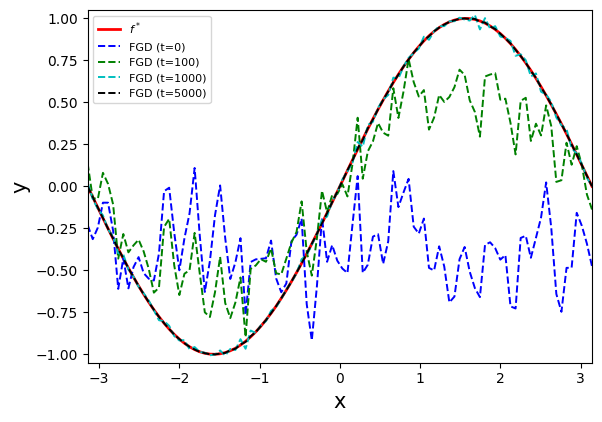

In [9]:
fgd_pred_t = [dict(f=fgd_logs[0], label=f"FGD (t=0)")]
fgd_pred_t.extend([dict(f=fgd_logs[i], label=f"FGD (t={i*100})") for i in range(1, 2, 1)])
fgd_pred_t.extend([dict(f=fgd_logs[i], label=f"FGD (t={i*100})") for i in range(10, 20, 10)])
fgd_pred_t.append(dict(f=fgd_logs[-1], label="FGD (t=5000)"))
plot_fn(x_train, y_train, *fgd_pred_t)
legend = functools.partial(plt.legend, fontsize=8)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

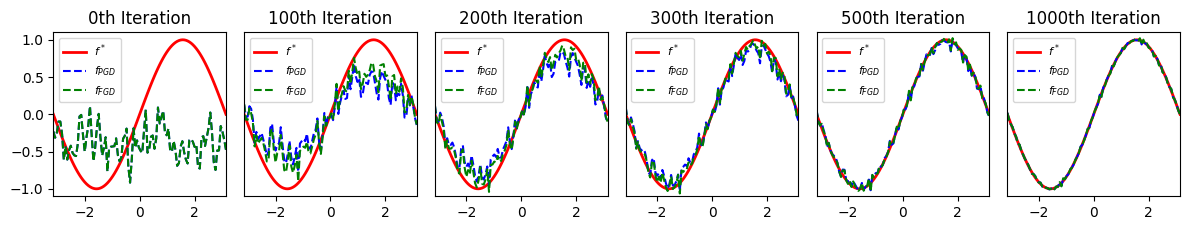

In [11]:
# compare mlp_fgd, mlp1_sgd, mlp2_sgd at steps 0, 100, 200, 500, 1000
plt.figure(figsize=(20, 8))
x, y = x_train.flatten(), y_train.flatten()
sorted_indices = jnp.argsort(x)
x, y = x[sorted_indices], y[sorted_indices]
for i, step in enumerate([0, 1, 2, 3, 5, 10]):
    plt.subplot(1, 6, i+1)
    sgd1_t= mlp1_preds[step].flatten()
    # sgd2_t= mlp2_preds[step].flatten()
    fgd_t= fgd_logs[step].flatten()

    plt.plot(x, y, 'r-', label='$f^*$', linewidth=2)
    plt.plot(x, sgd1_t[sorted_indices], 'b--', linewidth=1.5, label='$f_{PGD}$')
    plt.plot(x, fgd_t[sorted_indices], 'g--', linewidth=1.5, label='$f_{FGD}$')

    if i >0: 
        plt.yticks([]) 

    plt.xlim([-jnp.pi, jnp.pi])
    plt.ylim([-1.1, 1.1])
    plt.title(f"{step*100}th Iteration", fontsize=12)

    # format_plot('x', 'y', fontsize=15)
    legend = functools.partial(plt.legend, fontsize=8)
    legend(loc='upper left')
finalize_plot((1, 0.2))
plt.savefig('fgd_vs_pgd.pdf', dpi=500, bbox_inches='tight')